Behavioral Cloning P3
--

In [5]:
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Cropping2D
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import csv
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
from random import shuffle
import matplotlib.pyplot as plt
%matplotlib inline
use_official_data = True

In [6]:
angle_adjust = [0, 0.2, -0.2]
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                # center, left, right
                for i in range(3):
                    if use_official_data:
                        name = './data/IMG/' + batch_sample[i].split('/')[-1]
                    else:
                        name = './IMG/' + batch_sample[i].split('/')[-1]
                    image = cv2.imread(name)
                    image = cv2.resize(image, (0,0), fx=0.625, fy=0.625)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
                    angle = float(batch_sample[3]) + angle_adjust[i]
                    images.append(image)
                    angles.append(angle)
                    # flip image and angle
                    image_flipped = np.fliplr(image)
                    angle_flipped = -angle
                    images.append(image_flipped)
                    angles.append(angle_flipped)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [7]:
if use_official_data:
    drivinglog = './data/driving_log.csv'
else:
    drivinglog = './driving_log.csv'
samples = []
with open(drivinglog) as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
#         if float(line[3]) == 0:
#             continue
        samples.append(line)

BATCH_SIZE = 128
NB_EPOCH = 15

train_samples, validation_samples = train_test_split(samples, test_size=0.2)
train_generator = generator(train_samples, batch_size=BATCH_SIZE)
validation_generator = generator(validation_samples, batch_size=BATCH_SIZE)

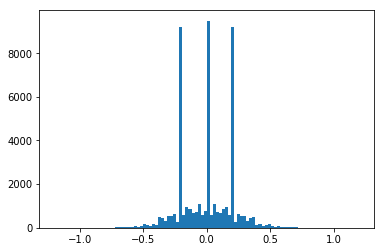

In [8]:
with open(drivinglog) as csvfile:
    angles = []
    reader = csv.reader(csvfile)
    for i, line in enumerate(reader):
        if i == 0:
            continue
        angle = float(line[3])
#         if angle == 0:
#             continue
        angles.append(angle)
        angles.append(-angle)

        angles.append(angle+0.2)
        angles.append(angle-0.2)
        angles.append(-angle-0.2)
        angles.append(-angle+0.2)
    
    print()
    plt.hist(angles, 100)
    plt.show()

In [9]:
model = Sequential()
# preprocessing
model.add(Cropping2D(cropping=((22,12), (0,0)), input_shape=(100,200,3)))
model.add(Lambda(lambda x: x / 255))

# https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/
model.add(Convolution2D(nb_filter=8, nb_row=7, nb_col=7, subsample=(1,1), border_mode='same'))
model.add(Activation('relu'))

model.add(Convolution2D(nb_filter=16, nb_row=5, nb_col=5, subsample=(1,1), border_mode='same'))
model.add(Activation('relu'))
# conv1 24@43x158
model.add(Convolution2D(nb_filter=24, nb_row=5, nb_col=5, subsample=(2,2), border_mode='valid'))
model.add(Activation('relu'))
# conv2 36@20x77
model.add(Convolution2D(nb_filter=36, nb_row=5, nb_col=5, subsample=(2,2), border_mode='valid'))
model.add(Activation('relu'))
# conv3 48@8x37
model.add(Convolution2D(nb_filter=48, nb_row=5, nb_col=5, subsample=(2,2), border_mode='valid'))
model.add(Activation('relu'))
# conv4 64@6x35
model.add(Convolution2D(nb_filter=64, nb_row=3, nb_col=3, subsample=(1,1), border_mode='valid'))
model.add(Activation('relu'))
# conv5 64@4x33
model.add(Convolution2D(nb_filter=64, nb_row=3, nb_col=3, subsample=(1,1), border_mode='valid'))
model.add(Activation('relu'))
model.add(Flatten())

# FC1
model.add(Dense(100))
model.add(Activation('relu'))
# FC2
model.add(Dense(50))
model.add(Activation('relu'))
# FC3
model.add(Dense(10))
model.add(Activation('relu'))
# Output
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
history = model.fit_generator(train_generator,
        samples_per_epoch=len(train_samples),
        validation_data=validation_generator,
        nb_val_samples=len(validation_samples),
        nb_epoch=NB_EPOCH, verbose=1)
model.save('model.h5')
print('model saved.')

Epoch 1/15
6144/6428 [===========================>..] - ETA: 1s - loss: 0.0425

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


6912/6428 [================================] - 35s - loss: 0.0422 - val_loss: 0.0395
Epoch 2/15
6912/6428 [================================] - 25s - loss: 0.0383 - val_loss: 0.0408
Epoch 3/15
6912/6428 [================================] - 25s - loss: 0.0338 - val_loss: 0.0305
Epoch 4/15
6912/6428 [================================] - 25s - loss: 0.0295 - val_loss: 0.0262
Epoch 5/15
6912/6428 [================================] - 24s - loss: 0.0241 - val_loss: 0.0250
Epoch 6/15
7080/6428 [=================================] - 28s - loss: 0.0268 - val_loss: 0.0254
Epoch 7/15
6912/6428 [================================] - 24s - loss: 0.0244 - val_loss: 0.0246
Epoch 8/15
6912/6428 [================================] - 25s - loss: 0.0226 - val_loss: 0.0210
Epoch 9/15
6912/6428 [================================] - 25s - loss: 0.0209 - val_loss: 0.0196
Epoch 10/15
6912/6428 [================================] - 24s - loss: 0.0216 - val_loss: 0.0210
Epoch 11/15
6912/6428 [==========================

dict_keys(['loss', 'val_loss'])


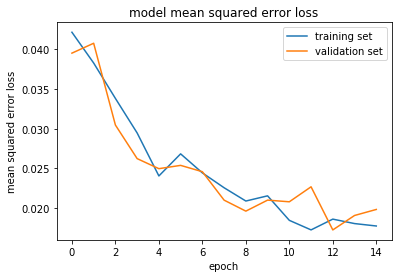

In [11]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [12]:
print(model.summary())


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_1 (Cropping2D)        (None, 66, 200, 3)    0           cropping2d_input_1[0][0]         
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 66, 200, 3)    0           cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 66, 200, 8)    1184        lambda_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 66, 200, 8)    0           convolution2d_1[0][0]            
___________________________________________________________________________________________